In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('../Data/shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.hidden_layer = nn.RNNCell(self.input_size,self.hidden_size) 
        self.output_layer = nn.Linear(self.hidden_size,self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.hidden_layer(input,hidden)
        output = self.output_layer(hidden)
        hidden = self.hidden_layer(output,hidden)
        output = self.output_layer(hidden)
        hidden = self.hidden_layer(output,hidden)
        output = self.output_layer(hidden)
        hidden = self.hidden_layer(output,hidden)
        output = self.output_layer(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (hidden_layer): RNNCell(100, 100)
  (output_layer): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 20000  # Number of training iterations.
print_iters = 200    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:3.3825855255126953
generated sequence: W e  nltc l o 
rNhfee do.omms e'a ie e
 ld esiieahcu ohon 'sSrAWrhblS c s Aic,
nwteaho nw otetyo   ge

iter:399/20000 loss:3.384984016418457
generated sequence: WNoO rIsr Se p et 
wscetetetswisTmEyo'hItlfaeo,e.slstsn 'Mdehshtiommonev u e
 itssioumewostnQ m  ecor

iter:599/20000 loss:3.3597757816314697
generated sequence: W iiweayaU tethp;bto;Cafhngst
UyIh lhwakWsrth peilinaeHysih rhIuah 
a soelot'di a bEset ds ic
nWbC i,

iter:799/20000 loss:3.376082181930542
generated sequence: W;i  dwcne hu
s y ltu em  rti Fwk,wOa,haaeyniehnh  ess I vh s ru NSbhhil ne u Ahtaul  Vletn i nfHt I 

iter:999/20000 loss:3.3674838542938232
generated sequence: Wyekyieip, yT.
muopod ofogdn
,h.eyEu
 d IIrur,er
i tec ldwI ncatti uitdn uVtnht ie
 .mgc
ote  wtn

i


iter:1199/20000 loss:3.394104242324829
generated sequence: Wmg eaewlasl  ,srrndv
 eleoy  lio- mfoeiahoguuowdrfwOasesm i'OeuaaR  reReO si. loiP gini
ht n- hnsi ?

iter:1399/20000 loss:3.3804571

#### Training Loss Curve

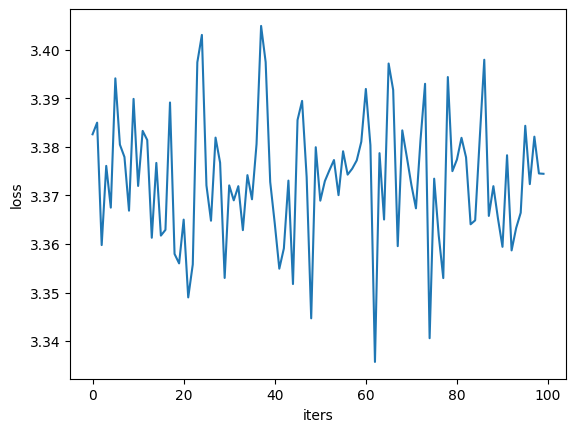

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss.item() for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

WhhNitdnv cb  u'rI
 fWnem

nt
tddsd l  ah
 W dvu en ,emk,inhn
 fye  SRiiiRsir'esea l u su bla  mr,  hecinp  e  s
f eee Ye:yciev:m evnnt edycTmc bsso h  iyTv gtei
oswhhehmRh elaoeS  t 
wu'sdhi   U:bkaer ieey
t leyiishe  de.o Ueknhe dc,etsyebahyCa oee 'cnLoe
 Oylm  taEie
 : tcLtyueap  O imo s eeoeuyrn en s gi
agbonhfesh  nhse aps hsetpiteosShiiirssHegeate  lsi HtIinoesln reaepdeM:aitd  tn
sCha
rh:n,onae aahp
ira
eu l dewe e'uhy wmsCah red tpi   Eo iaeh :ti'Tn
.eate nbh larrmIa beetife ft nbv:.iyntr hatn
inAueir ERrt gtrhrtiordnsh etgtn 
 thd o    e'hme:Nle
ohhes i scyeetehhshiuigphnua Wtnudt erh 


### Method
Added more hidden states to see if the output was sensible in earlier iterations.

### Evaluation

Interestingly, the addition of more hidden layers does not improve model performance when considering the loss. We can also tell that there is less sensible output as the sentences lack meaning, though there are a good amount of English spoken words.